# Movie Genre Classification

Movies are a popular means of entertainment all around the world. With a lot of streaming services and websites available and with more on the horizon, building a predictive model that automatically generates the genre of a movie based on the its plot summary is definitely beneficial as it may reduce the expense of manually tagging the movies.

# Data Understanding

## Preprocessing and Exploratory Data Analysis

#### IMPORT NEEDED PACKAGES


In [19]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from num2words import num2words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from collections import defaultdict
from collections import Counter
from tabulate import tabulate

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Information

In [21]:
# Loading the dataset
dataset_path = 'data/train_data.txt'
data = pd.read_csv(dataset_path, sep=',', engine='python', header=None)
data.columns = ['ID', 'TITLE', 'GENRE', 'DESCRIPTION']

In [22]:
print('Number of instances = %d' % (data.shape[0]))
print('Number of attributes = %d' % (data.shape[1]))
data.head()

Number of instances = 54214
Number of attributes = 4


,ID,TITLE,GENRE,DESCRIPTION
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


#### Data Types

In [23]:
# Printing data types of DataFrame
data.dtypes

ID              int64
TITLE          object
GENRE          object
DESCRIPTION    object
dtype: object

#### Dataframe Statistics

In [24]:
# Printing description of DataFrame
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,54214.0,27107.5,15650.378084,1.0,13554.25,27107.5,40660.75,54214.0


### Extract unique values of GENRE feature


In [25]:
# Convert values in 'GENRE' column to lowercase and remove leading/trailing whitespaces
data['GENRE'] = data['GENRE'].str.lower().str.strip()

In [27]:
# Extract unique genres
unique_genres = data['GENRE'].unique()

# Total number of unique genres
# Calculate frequency of each genre
genre_counts = data['GENRE'].value_counts()
total_unique_genres = len(genre_counts)


# Print total number of unique genres
print(f"Total number of unique genres/classes: {total_unique_genres}")

Total number of unique genres/classes: 26


### Print them with their frequency

In [28]:
# Print unique genres and their counts
print("\nUnique genres/classes in the 'Genre' attribute and their counts:")
for genre, count in genre_counts.items():
    print(f"{genre}: {count}")


Unique genres/classes in the 'Genre' attribute and their counts:
drama: 13613
documentary: 13096
comedy: 7447
short: 5073
horror: 2204
thriller: 1591
action: 1315
western: 1032
music: 1008
reality-tv: 884
family: 784
adventure: 775
romance: 672
sci-fi: 647
adult: 590
crime: 505
animation: 498
sport: 432
talk-show: 391
fantasy: 323
mystery: 319
biography: 265
history: 243
game-show: 194
news: 181
war: 132


### Plot them with their distribution

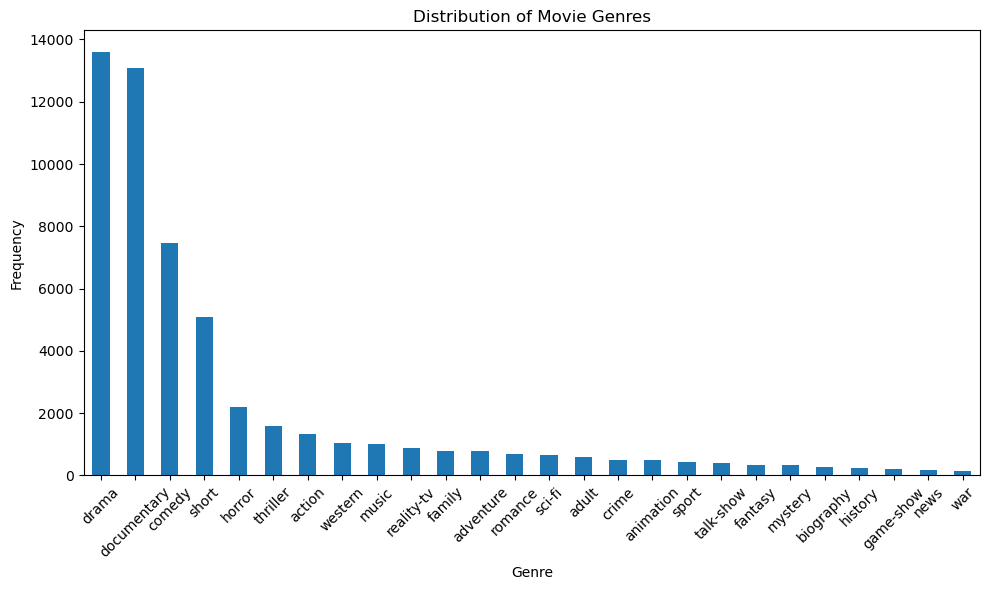

In [29]:
# Plotting
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#           Data Cleaning and Standardization

 ### Removing HTML tags if the data is scraped from the web

In [30]:
def remove_html_tags(text):
    clean_text = re.sub(r'<[^>]+>', '', text)
    return clean_text

 ### Removing special characters

In [31]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return clean_text

 ### Removing emojis and  non-standard symbols

In [32]:
# Define a regex pattern to match emojis and non-standard symbols
# This pattern targets characters outside the typical ASCII range, which includes most emojis and non-standard symbols
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"  # Enclosed characters
                           "]+", flags=re.UNICODE)

# Function to remove emojis and non-standard symbols
def remove_emojis_and_symbols(text):
    return emoji_pattern.sub(r'', text)

# Apply the function to remove emojis and non-standard symbols from DESCRIPTION
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_emojis_and_symbols)

###   Converting to Lowercase:

In [33]:
 # Convert DESCRIPTION column to lowercase
data['DESCRIPTION'] = data['DESCRIPTION'].str.lower()

### Fixing Encoding Issues

In [37]:
try:
    data = pd.read_csv('data/train_data.txt', 
                       sep=',', 
                       engine='python',
                       encoding='utf-8',  # Ensure UTF-8 encoding
                       on_bad_lines='skip',
                       quotechar='"', 
                       names=['ID', 'TITLE', 'GENRE', 'DESCRIPTION']
                      )
    print("Data loaded successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

Data loaded successfully.


###  Remove Extra Whitespace

In [38]:
def remove_extra_whitespace(text):
    words = text.split()
    clean_words = [word.strip() for word in words]
    clean_text = ' '.join(clean_words)
    return clean_text

# Apply the function to the DESCRIPTION column
data['CLEAN_DESCRIPTION'] = data['DESCRIPTION'].apply(remove_extra_whitespace)

### Handle Missing Values

In [39]:
# Handle missing values
data.dropna(inplace=True)

# Check for missing values
assert not data.isnull().values.any(), "Missing values are present in the data."

# Print success message
print("Missing values handled successfully.")

Missing values handled successfully.


### Normalization

In [40]:
# Define function to normalize numbers in a column
def normalize_numbers_column(column):
    number_pattern = r'\b\d[\d,.]*\b'
    return column.str.replace(number_pattern, 'NUMBER', regex=True)

### Non-informative words

In [41]:
df = pd.DataFrame(data)
# Download the set of stop words the first time
nltk.download('stopwords')

# Load the stop words
non_informative_words = set(stopwords.words('english'))

# Define the function to remove non-informative words
def remove_non_informative(text):
    # Split the text into words and remove non-informative words
    return ' '.join(word for word in text.split() if word.lower() not in non_informative_words)

# Assuming 'df' is your DataFrame and it has a column 'CLEAN_DESCRIPTION'
# Apply the function to remove non-informative words from 'CLEAN_DESCRIPTION'
df['CLEAN_DESCRIPTION'] = df['CLEAN_DESCRIPTION'].apply(remove_non_informative)

# Check again for non-informative words in 'CLEAN_DESCRIPTION'
df['contains_non_informative'] = df['CLEAN_DESCRIPTION'].apply(
    lambda x: any(word.lower() in non_informative_words for word in x.split())
)

# Display the DataFrame to verify the removal
display_df = df[['CLEAN_DESCRIPTION', 'contains_non_informative']]

# Summarize the checks
summary = {
    'Non-informative Words Removed': not df['contains_non_informative'].any()
}

summary

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'Non-informative Words Removed': True}

### checking cleanliness

In [42]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_html_tags)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("HTML tags were present and successfully removed.")
else:
    print("No HTML tags were found in the DESCRIPTION column.")

No HTML tags were found in the DESCRIPTION column.


In [43]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_special_characters)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("Special characters were present and successfully removed.")
else:
    print("No Special characters were found in the DESCRIPTION column.")

No Special characters were found in the DESCRIPTION column.


In [44]:
# Get the length of the DESCRIPTION column before removing HTML tags
original_length = len(data['DESCRIPTION'])

# Apply the function to remove HTML tags
data['DESCRIPTION'] = data['DESCRIPTION'].apply(remove_emojis_and_symbols
)
# Get the length of the DESCRIPTION column after removing HTML tags
cleaned_length = len(data['DESCRIPTION'])

# Check if the lengths are different
if original_length != cleaned_length:
    print("emojis and symbols were present and successfully removed.")
else:
    print("No emojis and symbols were found in the DESCRIPTION column.")

No emojis and symbols were found in the DESCRIPTION column.


In [45]:
def convert_to_lowercase(text):
    return text.lower()

# Apply the function to the DESCRIPTION column
data['CLEAN_DESCRIPTION'] = data['DESCRIPTION'].apply(convert_to_lowercase)

# Check if all text is converted to lowercase
is_lowercase = (data['DESCRIPTION'].str.lower() == data['CLEAN_DESCRIPTION']).all()

if is_lowercase:
    print("All text in the CLEAN_DESCRIPTION column is in lowercase.")
else:
    print("Not all text in the CLEAN_DESCRIPTION column is in lowercase.")

All text in the CLEAN_DESCRIPTION column is in lowercase.


### Handling Numbers

In [46]:
# Function to handle numbers (convert contextually relevant numbers to words and removes irrelevant ones.)
def handle_numbers(text):

    # Convert years to text (years often signify important context in movies)
    clean_text = re.sub(r'\b(17|20)\d{2}\b', lambda match: num2words(match.group()), text)
    
    # Convert significant numbers to text if they are relevant to your analysis.
    clean_text = re.sub(r'\b\d{1,2}\b', lambda match: num2words(match.group()), text)
    
    # Remove remaining numbers that might not be relevant
    clean_text = re.sub(r'\b\d+\b', '', text)
    
    return clean_text

# Applying the preprocessing function to the 'DESCRIPTION' column
data['CLEAN_DESCRIPTION'] = data['CLEAN_DESCRIPTION'].apply(handle_numbers)

### Tokenization, Stop Words Removal, and Handling Negations:

In [47]:
# Tokenization, Stop Words Removal, and Handling Negations
def preprocess_text(text):
    
    # Removing non-alphanumeric characters
    # This to make sure that we do not have like (film, 's, instead we will have films)
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    
    # Tokenizing the description
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    # Handling negations (e.g., "not good" becomes "not_good")
    for i in range(len(filtered_tokens)):
        if filtered_tokens[i] == 'not' and i + 1 < len(filtered_tokens):
            filtered_tokens[i + 1] = 'not_' + filtered_tokens[i + 1]

    return filtered_tokens

# Applying the preprocessing function to the 'DESCRIPTION' column
data['TOKENIZED_DESCRIPTION'] = data['CLEAN_DESCRIPTION'].apply(preprocess_text)

### Stemming

In [48]:
# Using NLTK's Snowball Stemmer (Porter2 Stemmer)
from nltk.stem import SnowballStemmer

# Initialize the Snowball Stemmer
stemmer = SnowballStemmer(language='english')

# Function to stem a list of tokens, returns tokenized data
def stem_tokens(tokenized_text):
    # Stem each token in the list
    stemmed_tokens = [stemmer.stem(token) for token in tokenized_text]
    return stemmed_tokens

# Applying the stemming function to the 'TOKENIZED_DESCRIPTION' column
data['STEMMED_DESCRIPTION'] = data['TOKENIZED_DESCRIPTION'].apply(stem_tokens)

### Lemmatization

In [49]:
# Using spaCy for Lemmatization
import spacy

# Load English tokenizer, tagger, parser, and NER
nlp = spacy.load("en_core_web_sm")

# Function to lemmatize a list of tokens
def lemmatize_tokens(tokens):
    # Join the tokens into a string
    text = ' '.join(tokens)
    # Apply spaCy's lemmatization
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return lemmatized_tokens

# Applying the Lemmatization function to the 'TOKENIZED_DESCRIPTION' column
data['LEMMATIZED_DESCRIPTION'] = data['TOKENIZED_DESCRIPTION'].apply(lemmatize_tokens)

In [28]:
# # Initialize the Porter Stemmer
# porter = PorterStemmer()

# # Function to stem a list of tokens, returns tokenized data
# def stem_tokens(tokenized_text):
#     # Stem each token in the list
#     stemmed_tokens = [porter.stem(token) for token in tokenized_text]
#     return stemmed_tokens

# # Applying the stemming function to the 'TOKENIZED_DESCRIPTION' column
# data['STEMMED_DESCRIPTION'] = data['TOKENIZED_DESCRIPTION'].apply(stem_tokens)

In [29]:
# # Initialize the WordNet lemmatizer
# lemmatizer = WordNetLemmatizer()

# # Function to lemmatize a list of tokens (tokennized description)
# def lemmatize_tokens(tokens):
#     # Lemmatize each token
#     lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
#     # Join the lemmatized tokens back into a string
#     return ' '.join(lemmatized_tokens)

# # Applying the Lemmatization function to the 'STEMMED_DESCRIPTION' column
# data['LEMMATIZED_DESCRIPTION'] = data['STEMMED_DESCRIPTION'].apply(lemmatize_tokens)

## Summary

In [50]:
# Assuming 'data' is your DataFrame and it has a column 'CLEAN_DESCRIPTION'
df = pd.DataFrame(data)

# 1. Check for HTML tags
html_tag_pattern = re.compile(r'<[^>]+>')
df['contains_html_tags'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(html_tag_pattern.search(x)))

# 2. Check for special characters
special_chars_pattern = re.compile(r'[@#$%]')
df['contains_special_chars'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(special_chars_pattern.search(x)))

# 3. Check for non-standard symbols or emojis
non_standard_pattern = re.compile(r'[^\w\s,.!?;:\-\(\)\'\"/]')
df['contains_non_standard_symbols'] = df['CLEAN_DESCRIPTION'].apply(lambda x: bool(non_standard_pattern.search(x)))

# 4. Check for lowercase text
df['is_lowercase'] = df['CLEAN_DESCRIPTION'].apply(lambda x: x.islower())

# 5 Apply the function to remove non-informative words from 'CLEAN_DESCRIPTION'
df['CLEAN_DESCRIPTION'] = df['CLEAN_DESCRIPTION'].apply(remove_non_informative)

# Check again for non-informative words in 'CLEAN_DESCRIPTION'
df['contains_non_informative'] = df['CLEAN_DESCRIPTION'].apply(
    lambda x: any(word.lower() in non_informative_words for word in x.split())
)

# 6 check for tokenization
df['is_tokenized'] = df['TOKENIZED_DESCRIPTION'].apply(lambda x: isinstance(x, list))

# 7 check for stemming
df['is_stemmed'] = df['STEMMED_DESCRIPTION'].apply(lambda x: isinstance(x, list))

# 8 check for lemmatization
df['is_lemmatized'] = df['LEMMATIZED_DESCRIPTION'].apply(lambda x: isinstance(x, list))

# Display the DataFrame to verify the removal
display_df = df[['CLEAN_DESCRIPTION', 'contains_non_informative']]

# Now summarize the checks
summary = {
    'HTML Tags': df['contains_html_tags'].any(),
    'Special Characters': df['contains_special_chars'].any(),
    'Non-standard Symbols/Emojis': df['contains_non_standard_symbols'].any(),
    'Lowercase Text': not df['is_lowercase'].all(),  
    'Tokenization Applied': df['is_tokenized'].all(),
    'Stemming Applied': df['is_stemmed'].all(),
    'Lemmatization Applied': df['is_lemmatized'].all(),
}

summary

{'HTML Tags': False,
 'Special Characters': False,
 'Non-standard Symbols/Emojis': False,
 'Lowercase Text': False,
 'Tokenization Applied': True,
 'Stemming Applied': True,
 'Lemmatization Applied': True}

In [51]:

df

,ID,TITLE,GENRE,DESCRIPTION,CLEAN_DESCRIPTION,TOKENIZED_DESCRIPTION,STEMMED_DESCRIPTION,LEMMATIZED_DESCRIPTION,contains_html_tags,contains_special_chars,contains_non_standard_symbols,is_lowercase,contains_non_informative,is_tokenized,is_stemmed,is_lemmatized
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents 10yearol...,"[listening, conversation, doctor, parents, 10y...","[listen, convers, doctor, parent, 10yearold, o...","[listen, conversation, doctor, parent, 10yearo...",False,False,False,True,False,True,True,True
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,"[brother, sister, past, incestuous, relationsh...","[brother, sister, past, incestu, relationship,...","[brother, sister, past, incestuous, relationsh...",False,False,False,True,False,True,True,True
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,"[bus, empties, students, field, trip, museum, ...","[bus, empti, student, field, trip, museum, nat...","[bus, empty, student, field, trip, museum, nat...",False,False,False,True,False,True,True,True
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,"[help, unemployed, father, make, ends, meet, e...","[help, unemploy, father, make, end, meet, edit...","[help, unemployed, father, make, end, meet, ed...",False,False,False,True,False,True,True,True
4,5,The Unrecovered (2007),drama,The films title refers not only to the unreco...,films title refers unrecovered bodies ground z...,"[films, title, refers, unrecovered, bodies, gr...","[film, titl, refer, unrecov, bodi, ground, zer...","[film, title, refer, unrecovered, body, ground...",False,False,False,True,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This shortlived NBC live sitcom centered on B...,shortlived nbc live sitcom centered bonino wor...,"[shortlived, nbc, live, sitcom, centered, boni...","[shortliv, nbc, live, sitcom, center, bonino, ...","[shortlive, nbc, live, sitcom, center, bonino,...",False,False,False,True,False,True,True,True
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION The siste...,next generation exploitation sisters kapa bay ...,"[next, generation, exploitation, sisters, kapa...","[next, generat, exploit, sister, kapa, bay, so...","[next, generation, exploitation, sister, kapa,...",False,False,False,True,False,True,True,True
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,Ze bestaan echt is a standup comedy about gro...,ze bestaan echt standup comedy growing facing ...,"[ze, bestaan, echt, standup, comedy, growing, ...","[ze, bestaan, echt, standup, comedi, grow, fac...","[ze, bestaan, echt, standup, comedy, grow, fac...",False,False,False,True,False,True,True,True
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...,walter vivian live country difficult time keep...,"[walter, vivian, live, country, difficult, tim...","[walter, vivian, live, countri, difficult, tim...","[walter, vivian, live, country, difficult, tim...",False,False,False,True,False,True,True,True


## Text Representation

### TF - IDF : Term Frequency-Inverse Document Frequency

***In this code:***

We join the tokenized words back into sentences because TfidfVectorizer expects an iterable of strings as input.

We initialize the TfidfVectorizer and fit it on the processed descriptions to learn the vocabulary and compute the IDF values.

We transform the processed descriptions into TF-IDF features.

Finally, we convert the TF-IDF features into a DataFrame for further analysis.

In [54]:
# Words to exclude
exclude_words = ['first', 'three', 'us', 'get','one','two']

# Join the tokenized words back into sentences
data['processed_description'] = data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer = TfidfVectorizer(max_features=5000,stop_words=exclude_words)

# Fit and transform the processed descriptions to get TF-IDF features
tfidf_features = tfidf_vectorizer.fit_transform(data['processed_description'])

# Convert the TF-IDF features into a DataFrame (optional)
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Now, tfidf_df contains TF-IDF features for each movie description
# You can concatenate this DataFrame with your original data if needed
print(tfidf_df)

       18th  1930s  1950  1950s  1960  1960s  1970  1970s  1980  19th  ...  \
0       0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
1       0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
2       0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
3       0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
4       0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
...     ...    ...   ...    ...   ...    ...   ...    ...   ...   ...  ...   
54209   0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
54210   0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
54211   0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
54212   0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   
54213   0.0    0.0   0.0    0.0   0.0    0.0   0.0    0.0   0.0   0.0  ...   

          young  youngster  youth  youtube  zealand  zen      z

In [55]:
data.head(10)

,ID,TITLE,GENRE,DESCRIPTION,CLEAN_DESCRIPTION,TOKENIZED_DESCRIPTION,STEMMED_DESCRIPTION,LEMMATIZED_DESCRIPTION,processed_description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening in to a conversation between his do...,"[listening, conversation, doctor, parents, 10y...","[listen, convers, doctor, parent, 10yearold, o...","[listen, conversation, doctor, parent, 10yearo...",listen conversation doctor parent 10yearold os...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,a brother and sister with a past incestuous r...,"[brother, sister, past, incestuous, relationsh...","[brother, sister, past, incestu, relationship,...","[brother, sister, past, incestuous, relationsh...",brother sister past incestuous relationship cu...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,as the bus empties the students for their fie...,"[bus, empties, students, field, trip, museum, ...","[bus, empti, student, field, trip, museum, nat...","[bus, empty, student, field, trip, museum, nat...",bus empty student field trip museum natural hi...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,to help their unemployed father make ends mee...,"[help, unemployed, father, make, ends, meet, e...","[help, unemploy, father, make, end, meet, edit...","[help, unemployed, father, make, end, meet, ed...",help unemployed father make end meet edith twi...
4,5,The Unrecovered (2007),drama,The films title refers not only to the unreco...,the films title refers not only to the unreco...,"[films, title, refers, unrecovered, bodies, gr...","[film, titl, refer, unrecov, bodi, ground, zer...","[film, title, refer, unrecovered, body, ground...",film title refer unrecovered body ground zero ...
5,6,Quality Control (2011),documentary,Quality Control consists of a series of 16mm ...,quality control consists of a series of 16mm ...,"[quality, control, consists, series, 16mm, sin...","[qualiti, control, consist, seri, 16mm, singl,...","[quality, control, consist, series, 16, mm, si...",quality control consist series 16 mm single ta...
6,7,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all...,in tough economic times max and joey have all...,"[tough, economic, times, max, joey, run, ideas...","[tough, econom, time, max, joey, run, idea, di...","[tough, economic, time, max, joey, run, idea, ...",tough economic time max joey run idea discover...
7,8,One Step Away (1985),crime,Ron Petrie Keanu Reeves is a troubled teen wh...,ron petrie keanu reeves is a troubled teen wh...,"[ron, petrie, keanu, reeves, troubled, teen, w...","[ron, petri, keanu, reev, troubl, teen, whose,...","[ron, petrie, keanu, reeve, troubled, teen, wh...",ron petrie keanu reeve troubled teen whose lif...
8,9,"""Desperate Hours"" (2016)",reality-tv,A sudden calamitous event causing great loss ...,a sudden calamitous event causing great loss ...,"[sudden, calamitous, event, causing, great, lo...","[sudden, calamit, event, caus, great, loss, li...","[sudden, calamitous, event, cause, great, loss...",sudden calamitous event cause great loss life ...
9,10,Spirits (2014/I),horror,Four high school students embark on a terrify...,four high school students embark on a terrify...,"[four, high, school, students, embark, terrify...","[four, high, school, student, embark, terrifi,...","[four, high, school, student, embark, terrifyi...",four high school student embark terrifying jou...


### Plot the top words of each GENRE

In [57]:
# Selecting the desired columns
processed_data = data[['ID', 'TITLE', 'GENRE', 'processed_description']]

# Saving the new DataFrame to a CSV file
# processed_data.to_csv('processed_data.csv', index=False)

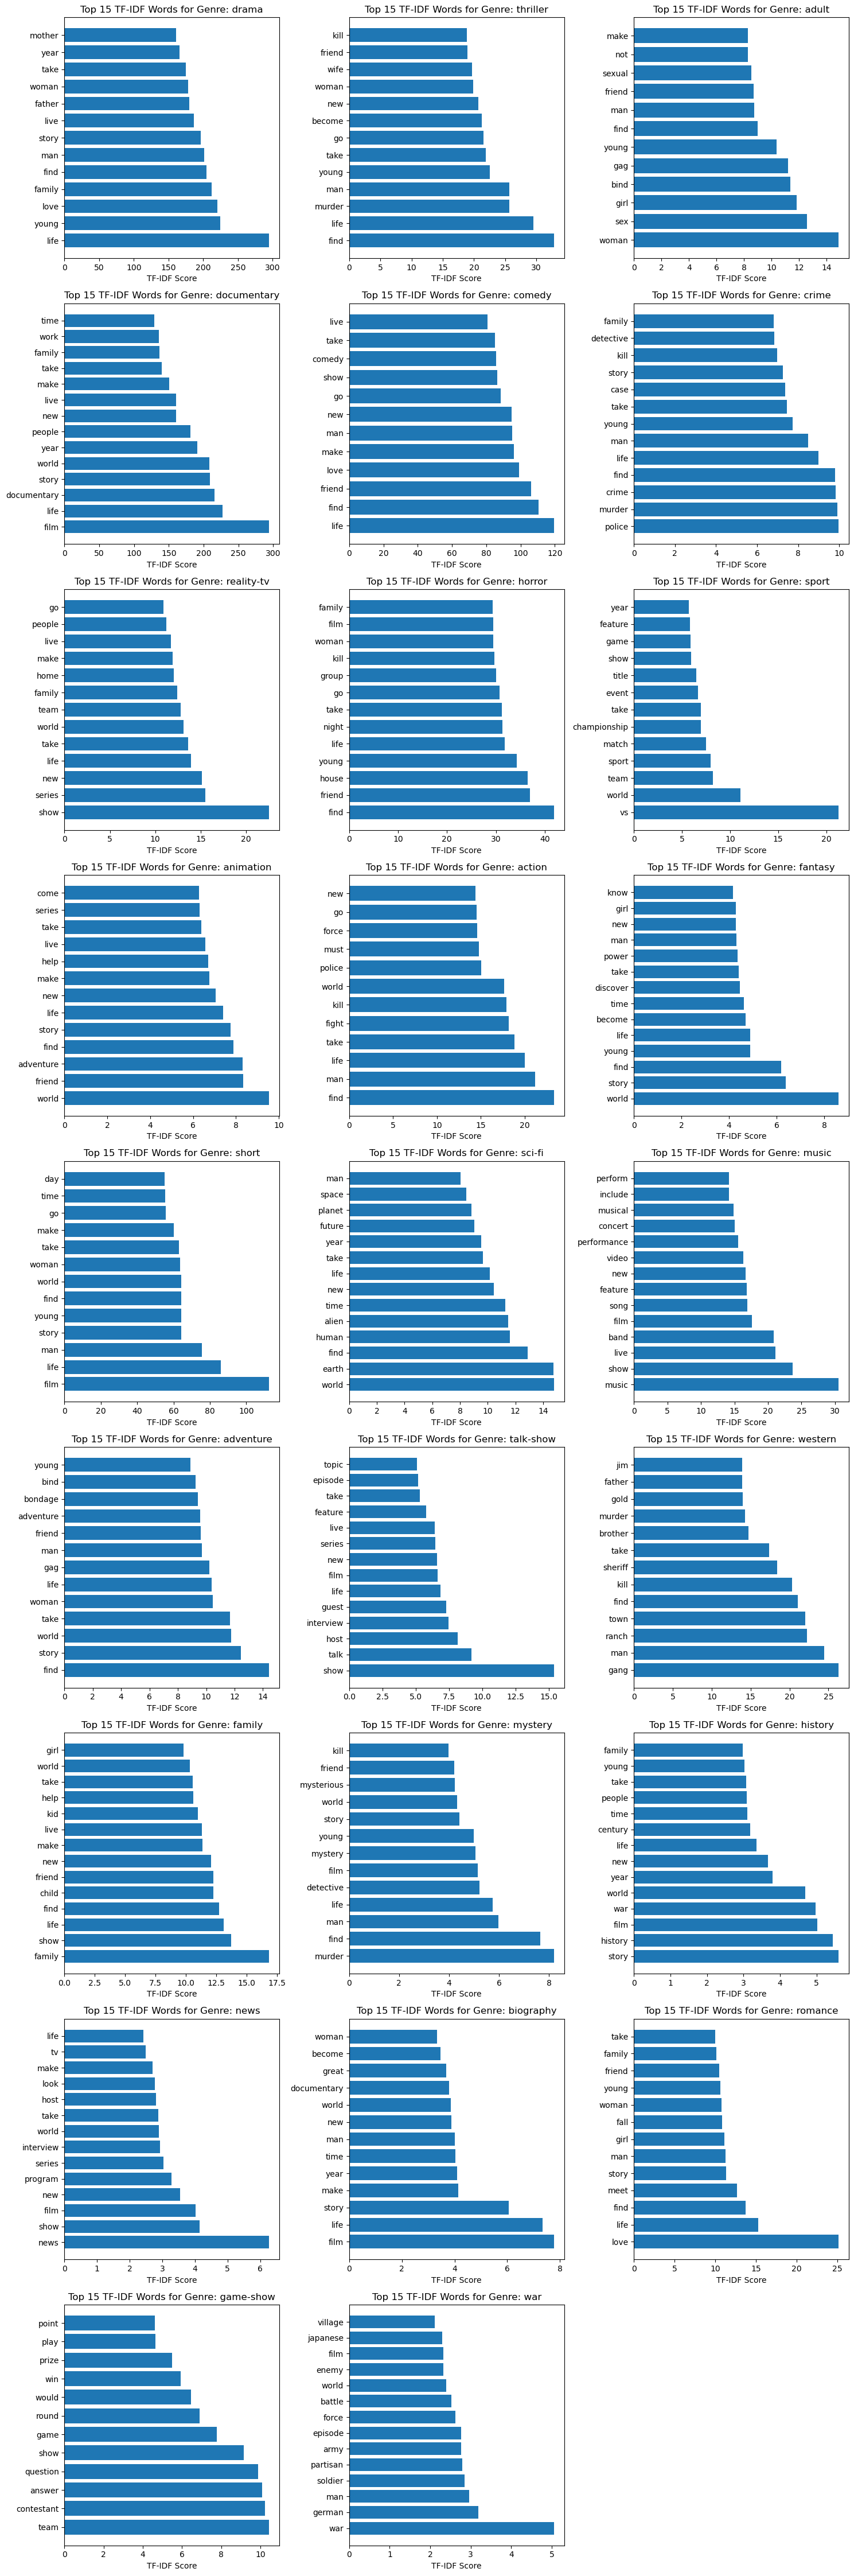

In [58]:
# Words to exclude
exclude_words = ['one','two','first', 'three', 'us', 'get']

# Assuming you have a 'genre' column in your dataframe
genres = data['GENRE'].unique()

# Initialize a dictionary to store TF-IDF scores for each genre
genre_tfidf = {}

# Initialize subplots
num_genres = len(genres)
num_cols = 3
num_rows = (num_genres // num_cols) + (1 if num_genres % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over each genre
for i, genre in enumerate(genres):
    # Filter data for the current genre
    genre_data = data[data['GENRE'] == genre]
    
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()
    
    # Fit and transform description for the current genre
    tfidf_features = tfidf_vectorizer.fit_transform(genre_data['processed_description'])
    
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Sum TF-IDF scores for each feature across all documents
    tfidf_scores = tfidf_features.sum(axis=0).A1
    
    # Create a dictionary with feature names as keys and TF-IDF scores as values
    genre_tfidf[genre] = dict(zip(feature_names, tfidf_scores))
    
    # Get top 15 words and their TF-IDF scores for the current genre
    top_words = sorted(genre_tfidf[genre].items(), key=lambda x: x[1], reverse=True)[:15]
    words, scores = zip(*top_words)
    
    # Remove excluded words
    words = [word for word in words if word not in exclude_words]
    scores = [score for word, score in top_words if word not in exclude_words]
    
    # Plot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.barh(range(len(words)), scores, align='center')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.set_xlabel('TF-IDF Score')
    ax.set_title(f'Top 15 TF-IDF Words for Genre: {genre}')

# Remove empty subplots
for i in range(num_genres, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')
plt.tight_layout()
plt.show()   

### APPLY THE BAG OF WORDS ON THE DATA:

In [61]:
# Words to exclude
exclude_words = ['one','two','first', 'three', 'us', 'get']

# Assuming you have a 'genre' column in your dataframe
genres = data['GENRE'].unique()

# Initialize a dictionary to store Bag of Words counts for each genre
genre_bow = {}

# Iterate over each genre
for genre in genres:
    # Filter data for the current genre
    genre_data = data[data['GENRE'] == genre]
    
    # Join the tokenized words back into sentences
    genre_data['processed_description2'] = genre_data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
    
    # Initialize the CountVectorizer with excluded words
    count_vectorizer = CountVectorizer(stop_words=exclude_words)
    
    # Fit and transform the processed descriptions to get Bag of Words features
    bow_features = count_vectorizer.fit_transform(genre_data['processed_description2'])
    
    # Get feature names
    feature_names = count_vectorizer.get_feature_names_out()
    
    # Sum the Bag of Words counts for each feature across all documents
    bow_counts = bow_features.sum(axis=0).A1
    
    # Create a dictionary with feature names as keys and Bag of Words counts as values
    genre_bow[genre] = dict(zip(feature_names, bow_counts))

# Now, genre_bow contains Bag of Words counts for each genre


C:\Users\DELL\AppData\Local\Temp\ipykernel_13032\964964705.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
C:\Users\DELL\AppData\Local\Temp\ipykernel_13032\964964705.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_data['processed_description2'] = genre_data['LEMMATIZED_DESCRIPTION'].apply(lambda x: ' '.join(x))
C:\Users\DELL\AppData\Local\Temp\ipykernel_13032\964964705.py:16: SettingWithC

## Plot the top words of each GENRE

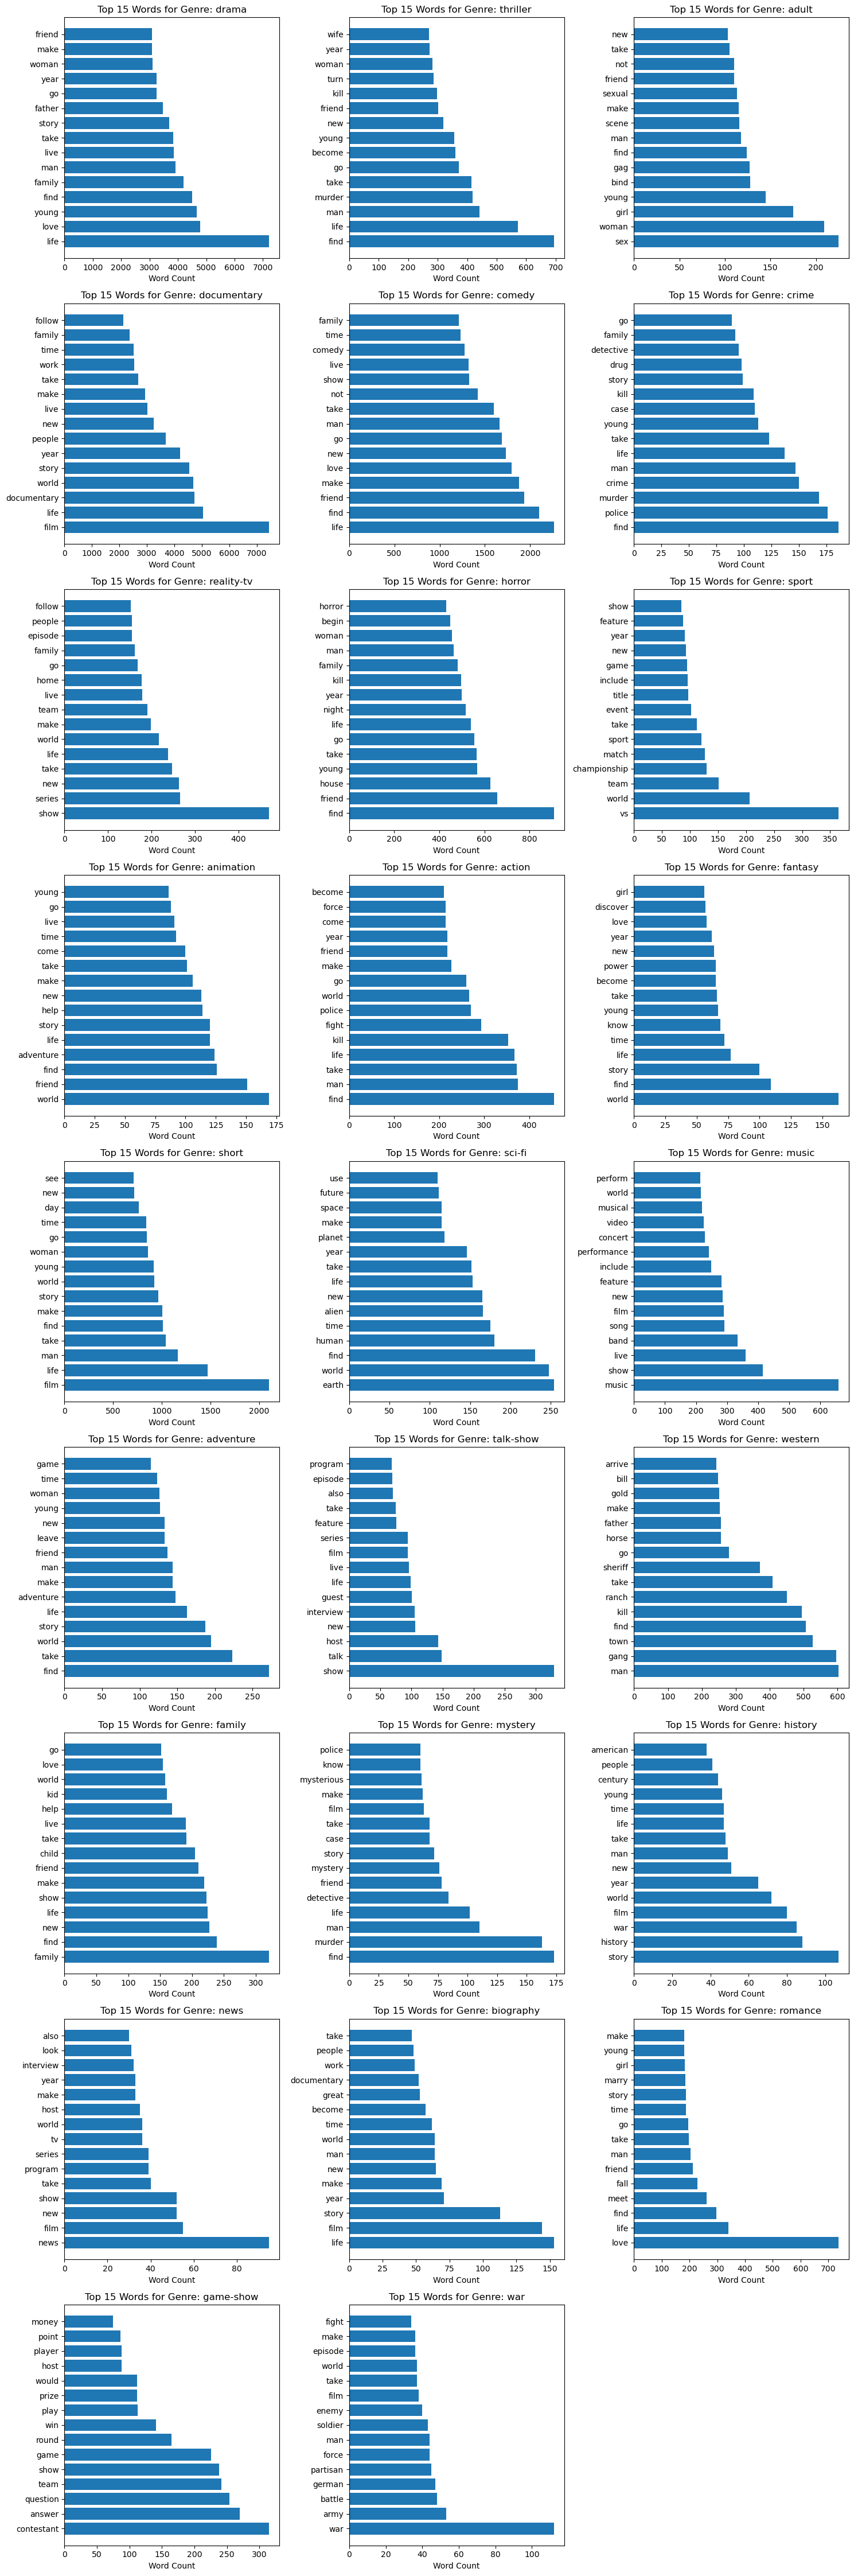

In [62]:
# Initialize subplots
num_genres = len(genres)
num_cols = 3
num_rows = (num_genres // num_cols) + (1 if num_genres % num_cols != 0 else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Iterate over each genre
for i, genre in enumerate(genres):
    # Get Bag of Words counts for the current genre
    bow_counts = genre_bow[genre]
    
    # Sort the dictionary by value (word counts)
    sorted_bow_counts = sorted(bow_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Get top 15 words and their counts for the current genre
    top_words = sorted_bow_counts[:15]
    words, counts = zip(*top_words)
    
    # Plot
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.barh(range(len(words)), counts, align='center')
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words)
    ax.set_xlabel('Word Count')
    ax.set_title(f'Top 15 Words for Genre: {genre}')

# Remove empty subplots
for i in range(num_genres, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

# Modeling

## Label Encoding: encode the target variable 'genre':

In [63]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'GENRE' column
data['GENRE_ENCODED'] = label_encoder.fit_transform(data['GENRE'])

# Store the mapping for later use if needed
genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

### Print the unique genres along with their encodings

In [64]:
# Print the unique genres along with their encodings
for genre, encoding in genre_mapping.items():
    print(f"{genre}: {encoding}")


action: 0
adult: 1
adventure: 2
animation: 3
biography: 4
comedy: 5
crime: 6
documentary: 7
drama: 8
family: 9
fantasy: 10
game-show: 11
history: 12
horror: 13
music: 14
mystery: 15
news: 16
reality-tv: 17
romance: 18
sci-fi: 19
short: 20
sport: 21
talk-show: 22
thriller: 23
war: 24
western: 25


In [65]:
data.head(3)

,ID,TITLE,GENRE,DESCRIPTION,CLEAN_DESCRIPTION,TOKENIZED_DESCRIPTION,STEMMED_DESCRIPTION,LEMMATIZED_DESCRIPTION,processed_description,GENRE_ENCODED
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening in to a conversation between his do...,"[listening, conversation, doctor, parents, 10y...","[listen, convers, doctor, parent, 10yearold, o...","[listen, conversation, doctor, parent, 10yearo...",listen conversation doctor parent 10yearold os...,8
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,a brother and sister with a past incestuous r...,"[brother, sister, past, incestuous, relationsh...","[brother, sister, past, incestu, relationship,...","[brother, sister, past, incestuous, relationsh...",brother sister past incestuous relationship cu...,23
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,as the bus empties the students for their fie...,"[bus, empties, students, field, trip, museum, ...","[bus, empti, student, field, trip, museum, nat...","[bus, empty, student, field, trip, museum, nat...",bus empty student field trip museum natural hi...,1


## Splitting Data

70% of the data will be used for training (X_train and y_train), and 30% will be used for validation (X_val and y_val).

In [67]:
# Step 1: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    data['CLEAN_DESCRIPTION'],
    data['GENRE_ENCODED'],
    test_size=0.2,  # Change test_size to 20% for validation
    random_state=42
)

# Step 2: Load separate test file
dataset_path = 'data/test_data_preprocessed_with_target.txt'
test_data = pd.read_csv(dataset_path, sep='/', engine='python', header=None)
test_data.columns = ['ID', 'TITLE', 'processed_description', 'GENRE_ENCODED_TEST']

# Step 3: Prepare features for the test set
X_test = test_data['processed_description']

# Test data labels
y_test = test_data['GENRE_ENCODED_TEST']

In [68]:
print("TF-IDF Features Shape:", tfidf_features.shape)
print("Target Variable Shape:", data['GENRE_ENCODED'].shape)

TF-IDF Features Shape: (132, 2895)
Target Variable Shape: (54214,)


# Random Forest Model

In [69]:
# Create a TF-IDF Vectorizer and Random Forest classifier pipeline
rf_model_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier(n_estimators=100, random_state=42))

# Train the model on the training set
rf_model_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = rf_model_pipeline.predict(X_val)

# Evaluate the model's performance on the validation set
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred_rf))

# Optionally, you can also predict on the test set and evaluate
y_test_pred_rf = rf_model_pipeline.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred_rf))
print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred_rf))

Validation Set Accuracy: 0.4679516738909896
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       1.00      0.01      0.02       112
           2       0.80      0.03      0.06       139
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        61
           5       0.53      0.17      0.26      1443
           6       1.00      0.01      0.02       107
           7       0.53      0.90      0.67      2659
           8       0.40      0.85      0.55      2697
           9       1.00      0.03      0.05       150
          10       0.00      0.00      0.00        74
          11       1.00      0.12      0.22        40
          12       0.00      0.00      0.00        45
          13       0.79      0.03      0.05       431
          14       0.89      0.04      0.08       194
          15       0.00      0.00      0.00        5

C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Test Set Accuracy: 0.4516236162361624
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.00      0.01      1314
           1       0.00      0.00      0.00       590
           2       0.80      0.02      0.04       775
           3       0.00      0.00      0.00       498
           4       0.00      0.00      0.00       264
           5       0.42      0.32      0.37      7446
           6       0.00      0.00      0.00       505
           7       0.54      0.84      0.66     13096
           8       0.40      0.80      0.53     13612
           9       0.00      0.00      0.00       783
          10       0.00      0.00      0.00       322
          11       0.91      0.16      0.27       193
          12       0.00      0.00      0.00       243
          13       0.80      0.05      0.10      2204
          14       0.71      0.11      0.18       731
          15       0.00      0.00      0.00       276
          

C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

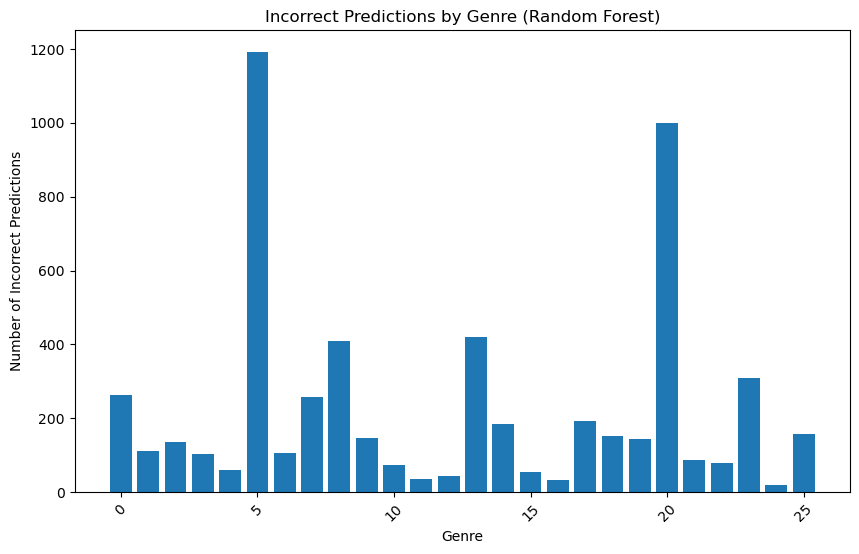

In [90]:
# Store predictions made by each model
rf_wrong_predictions = (y_val != y_val_pred_rf).astype(int)
xgb_wrong_predictions = (y_val != y_val_pred).astype(int)
svc_wrong_predictions = (y_val != y_val_pred).astype(int)

# Count incorrect predictions for each genre for rf
genre_counts = defaultdict(int)
for genre, wrong_pred in zip(y_val, rf_wrong_predictions):
    genre_counts[genre] += wrong_pred

# Plot incorrect predictions for each genre for rf
plt.figure(figsize=(10, 6))
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xlabel('Genre')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Incorrect Predictions by Genre (Random Forest)')
plt.xticks(rotation=45)
plt.show()

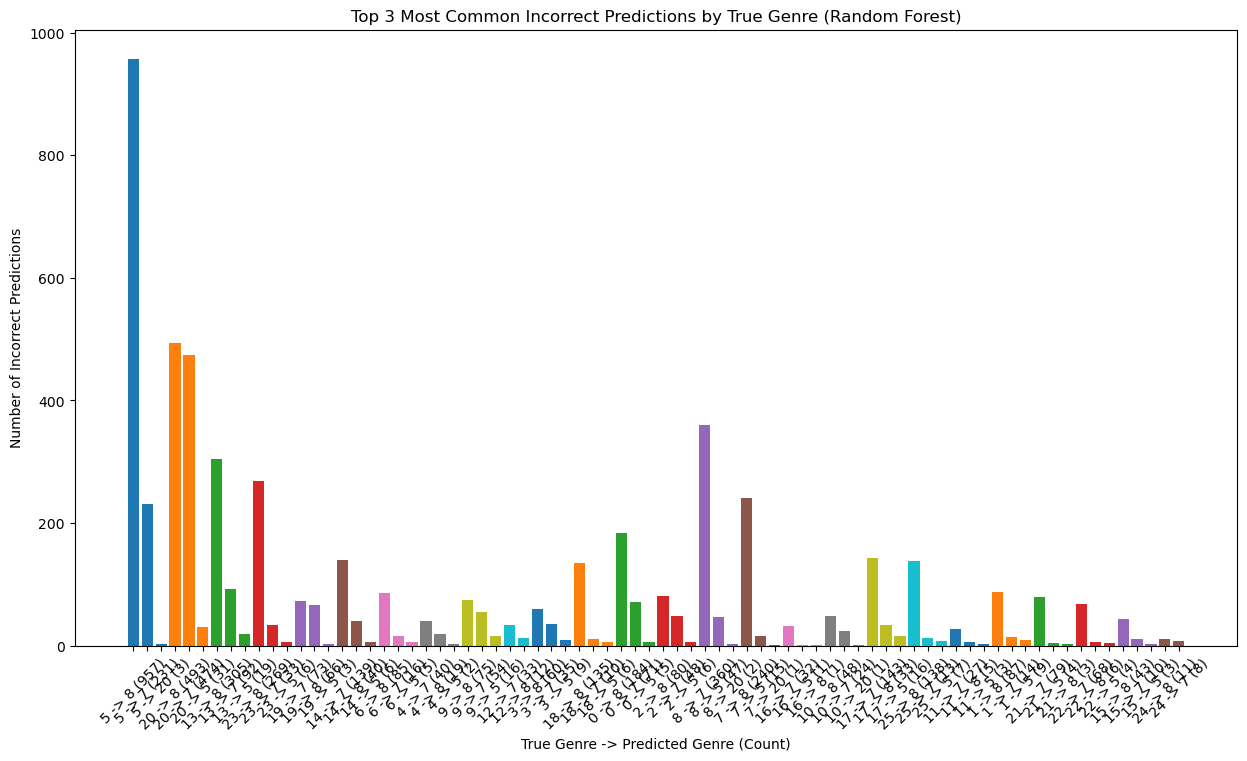

In [93]:
# Create defaultdict to store predicted genres for incorrect predictions by Random Forest
rf_wrong_genre_predictions = defaultdict(list)

# Loop through the predictions and store the predicted genres for each incorrect prediction by Random Forest
for true_genre, rf_pred in zip(y_val, y_val_pred_rf):
    if rf_pred != true_genre:  # Only consider cases where the prediction is wrong
        rf_wrong_genre_predictions[true_genre].append(rf_pred)

# Create a Counter object to count the occurrences of each incorrect prediction within each true genre
top_incorrect_predictions_rf = defaultdict(Counter)

# Loop through the wrong predictions for each true genre
for true_genre, pred_genres in rf_wrong_genre_predictions.items():
    # Count the occurrences of each predicted genre
    prediction_counter = Counter(pred_genres)
    # Get the top 3 most common incorrect predictions for the current true genre
    top_incorrect = prediction_counter.most_common(3)
    # Store the top 3 most common incorrect predictions for the current true genre
    top_incorrect_predictions_rf[true_genre] = top_incorrect

# Plot the top 3 most common incorrect predictions for each true genre
plt.figure(figsize=(15, 8))
for true_genre, top_incorrect in top_incorrect_predictions_rf.items():
    pred_genres = [f"{pair[0]} ({pair[1]})" for pair in top_incorrect]
    plt.bar([f"{true_genre} -> {pred_genre}" for pred_genre in pred_genres], [pair[1] for pair in top_incorrect])
plt.xlabel('True Genre -> Predicted Genre (Count)')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Top 3 Most Common Incorrect Predictions by True Genre (Random Forest)')
plt.xticks(rotation=45)
plt.show()

In [94]:
# Prepare the data for tabulation for Random Forest
table_data_rf = []
for true_genre, top_incorrect in top_incorrect_predictions_rf.items():
    row = [f"{true_genre} -> {pair[0]} ({pair[1]})" for pair in top_incorrect]
    table_data_rf.append(row)

# Display the table for Random Forest
print(tabulate(table_data_rf, headers=["True Genre -> Predicted Genre (Count)"] * 3, tablefmt="grid"))

+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| True Genre -> Predicted Genre (Count)   | True Genre -> Predicted Genre (Count)   | True Genre -> Predicted Genre (Count)   |
+=========================================+=========================================+=========================================+
| 5 -> 8 (957)                            | 5 -> 7 (231)                            | 5 -> 20 (3)                             |
+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| 20 -> 8 (493)                           | 20 -> 7 (474)                           | 20 -> 5 (31)                            |
+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| 13 -> 8 (305)                           | 13 -> 7 (92)                            | 13 -> 5 (19)      

# Gradient Boosting

In [70]:
xgb_model_pipeline = make_pipeline(TfidfVectorizer(), XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))

# Train the model on the training set
xgb_model_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = xgb_model_pipeline.predict(X_val)

# Evaluate the model's performance on the validation set
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))

# Optionally, you can also predict on the test set and evaluate
y_test_pred = xgb_model_pipeline.predict(X_test)
print("Test Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.545789910541363
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.18      0.26       263
           1       0.60      0.24      0.34       112
           2       0.36      0.14      0.20       139
           3       0.33      0.07      0.11       104
           4       0.00      0.00      0.00        61
           5       0.52      0.46      0.49      1443
           6       0.18      0.04      0.06       107
           7       0.64      0.82      0.71      2659
           8       0.49      0.78      0.60      2697
           9       0.34      0.07      0.11       150
          10       0.00      0.00      0.00        74
          11       0.88      0.53      0.66        40
          12       0.00      0.00      0.00        45
          13       0.61      0.48      0.54       431
          14       0.62      0.41      0.49       194
          15       0.33      0.02      0.03        56

C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Test Set Accuracy: 0.42088560885608856
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.37      0.17      0.23      1314
           1       0.40      0.22      0.28       590
           2       0.36      0.17      0.23       775
           3       0.19      0.03      0.06       498
           4       0.00      0.00      0.00       264
           5       0.39      0.59      0.47      7446
           6       0.14      0.16      0.15       505
           7       0.63      0.67      0.65     13096
           8       0.51      0.54      0.52     13612
           9       0.18      0.07      0.10       783
          10       0.38      0.03      0.05       322
          11       0.48      0.58      0.53       193
          12       0.00      0.00      0.00       243
          13       0.54      0.46      0.50      2204
          14       0.36      0.59      0.44       731
          15       0.00      0.00      0.00       276
         

C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

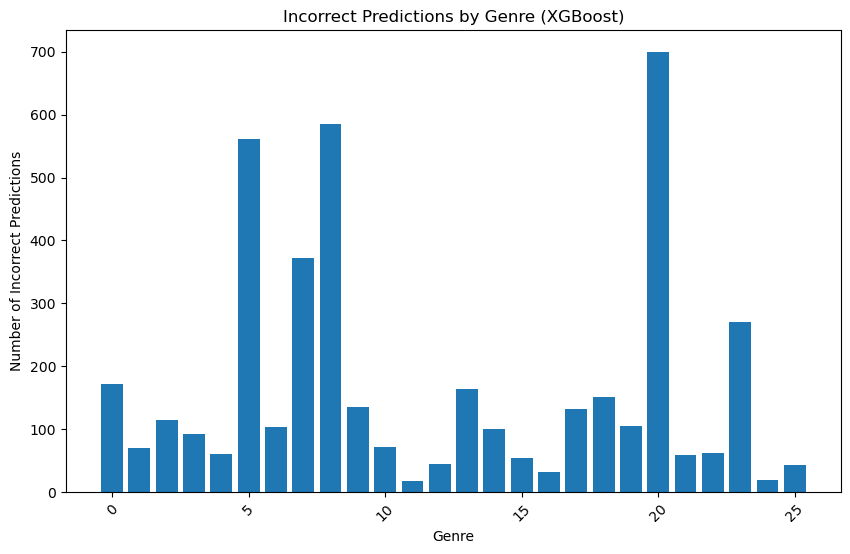

In [88]:
# Count incorrect predictions for each genre for XGBoost
xgb_genre_counts = defaultdict(int)
for genre, wrong_pred in zip(y_val, xgb_wrong_predictions):
    xgb_genre_counts[genre] += wrong_pred

# Plot incorrect predictions for each genre for XGBoost
plt.figure(figsize=(10, 6))
plt.bar(xgb_genre_counts.keys(), xgb_genre_counts.values())
plt.xlabel('Genre')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Incorrect Predictions by Genre (XGBoost)')
plt.xticks(rotation=45)
plt.show()

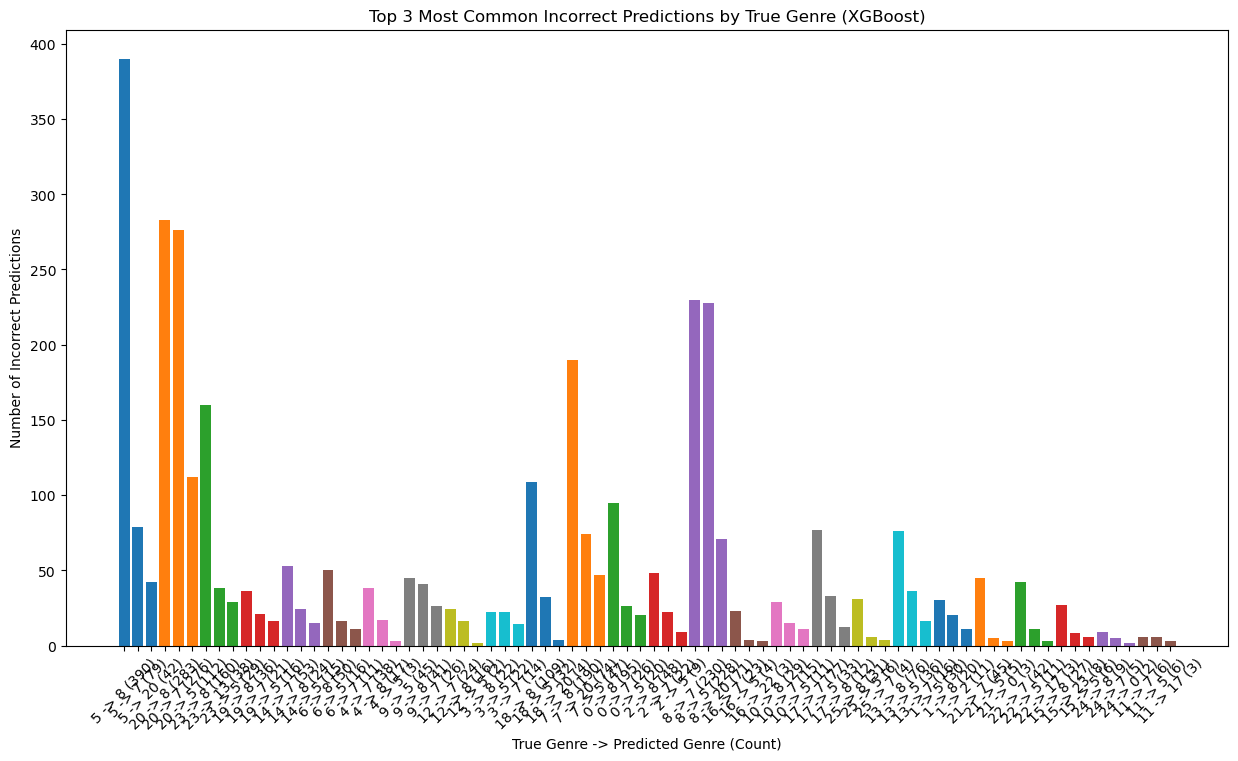

In [95]:
# Create defaultdict to store predicted genres for incorrect predictions by XGBoost
xgb_wrong_genre_predictions = defaultdict(list)

# Loop through the predictions and store the predicted genres for each incorrect prediction by XGBoost
for true_genre, xgb_pred in zip(y_val, y_val_pred):
    if xgb_pred != true_genre:  # Only consider cases where the prediction is wrong
        xgb_wrong_genre_predictions[true_genre].append(xgb_pred)

# Create a Counter object to count the occurrences of each incorrect prediction within each true genre
top_incorrect_predictions_xgb = defaultdict(Counter)

# Loop through the wrong predictions for each true genre
for true_genre, pred_genres in xgb_wrong_genre_predictions.items():
    # Count the occurrences of each predicted genre
    prediction_counter = Counter(pred_genres)
    # Get the top 3 most common incorrect predictions for the current true genre
    top_incorrect = prediction_counter.most_common(3)
    # Store the top 3 most common incorrect predictions for the current true genre
    top_incorrect_predictions_xgb[true_genre] = top_incorrect

# Plot the top 3 most common incorrect predictions for each true genre
plt.figure(figsize=(15, 8))
for true_genre, top_incorrect in top_incorrect_predictions_xgb.items():
    pred_genres = [f"{pair[0]} ({pair[1]})" for pair in top_incorrect]
    plt.bar([f"{true_genre} -> {pred_genre}" for pred_genre in pred_genres], [pair[1] for pair in top_incorrect])
plt.xlabel('True Genre -> Predicted Genre (Count)')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Top 3 Most Common Incorrect Predictions by True Genre (XGBoost)')
plt.xticks(rotation=45)
plt.show()

In [96]:
# Prepare the data for tabulation for XGBoost
table_data_xgb = []
for true_genre, top_incorrect in top_incorrect_predictions_xgb.items():
    row = [f"{true_genre} -> {pair[0]} ({pair[1]})" for pair in top_incorrect]
    table_data_xgb.append(row)

# Display the table for XGBoost
print(tabulate(table_data_xgb, headers=["True Genre -> Predicted Genre (Count)"] * 3, tablefmt="grid"))

+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| True Genre -> Predicted Genre (Count)   | True Genre -> Predicted Genre (Count)   | True Genre -> Predicted Genre (Count)   |
+=========================================+=========================================+=========================================+
| 5 -> 8 (390)                            | 5 -> 7 (79)                             | 5 -> 20 (42)                            |
+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| 20 -> 8 (283)                           | 20 -> 7 (276)                           | 20 -> 5 (112)                           |
+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| 23 -> 8 (160)                           | 23 -> 13 (38)                           | 23 -> 5 (29)      

# SVC Model

In [72]:
# Create a pipeline with TF-IDF vectorization and SVC
svc_pipeline = make_pipeline(TfidfVectorizer(), SVC(kernel='linear'))

# Train the SVC model on the training data
svc_pipeline.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = svc_pipeline.predict(X_val)

# Evaluate the model's performance
print("Validation Set Accuracy:", accuracy_score(y_val, y_val_pred))
print("Validation Set Classification Report:\n", classification_report(y_val, y_val_pred))

Validation Set Accuracy: 0.6035230102370193
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.35      0.42       263
           1       0.76      0.38      0.50       112
           2       0.44      0.17      0.25       139
           3       0.61      0.11      0.18       104
           4       0.00      0.00      0.00        61
           5       0.54      0.61      0.57      1443
           6       0.30      0.03      0.05       107
           7       0.68      0.86      0.76      2659
           8       0.56      0.78      0.65      2697
           9       0.45      0.09      0.15       150
          10       0.50      0.03      0.05        74
          11       0.96      0.55      0.70        40
          12       0.00      0.00      0.00        45
          13       0.67      0.62      0.64       431
          14       0.64      0.48      0.55       194
          15       1.00      0.02      0.04        5

C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\AppData\Local\anaconda3\envs\DM_ENV\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

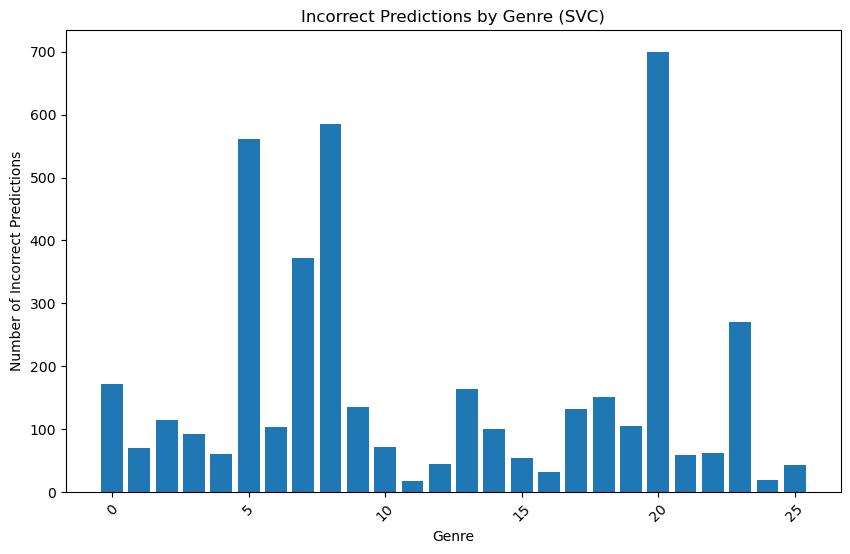

In [87]:
# Count incorrect predictions for each genre for SVC
svc_genre_counts = defaultdict(int)
for genre, wrong_pred in zip(y_val, svc_wrong_predictions):
    svc_genre_counts[genre] += wrong_pred

# Plot incorrect predictions for each genre for SVC
plt.figure(figsize=(10, 6))
plt.bar(svc_genre_counts.keys(), svc_genre_counts.values())
plt.xlabel('Genre')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Incorrect Predictions by Genre (SVC)')
plt.xticks(rotation=45)
plt.show()

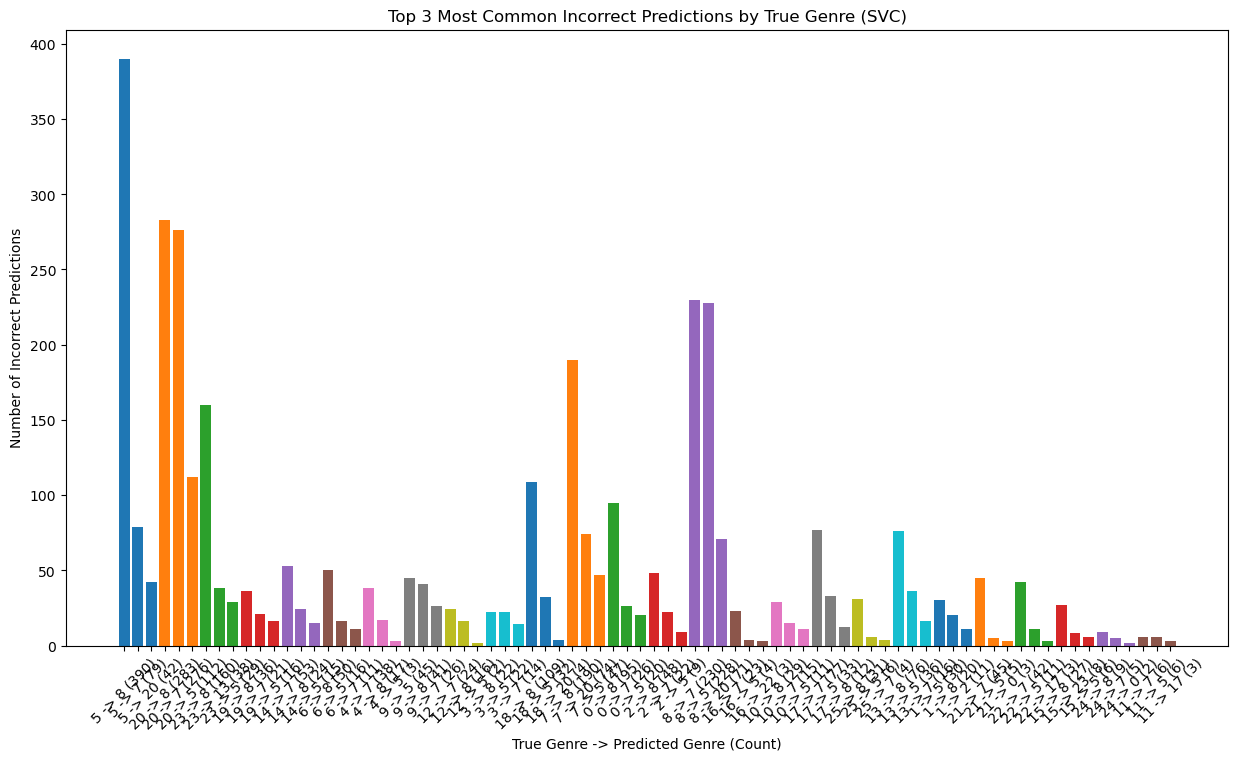

In [97]:
# Create defaultdict to store predicted genres for incorrect predictions by SVC
svc_wrong_genre_predictions = defaultdict(list)

# Loop through the predictions and store the predicted genres for each incorrect prediction by SVC
for true_genre, svc_pred in zip(y_val, y_val_pred):
    if svc_pred != true_genre:  # Only consider cases where the prediction is wrong
        svc_wrong_genre_predictions[true_genre].append(svc_pred)

# Create a Counter object to count the occurrences of each incorrect prediction within each true genre
top_incorrect_predictions_svc = defaultdict(Counter)

# Loop through the wrong predictions for each true genre
for true_genre, pred_genres in svc_wrong_genre_predictions.items():
    # Count the occurrences of each predicted genre
    prediction_counter = Counter(pred_genres)
    # Get the top 3 most common incorrect predictions for the current true genre
    top_incorrect = prediction_counter.most_common(3)
    # Store the top 3 most common incorrect predictions for the current true genre
    top_incorrect_predictions_svc[true_genre] = top_incorrect

# Plot the top 3 most common incorrect predictions for each true genre
plt.figure(figsize=(15, 8))
for true_genre, top_incorrect in top_incorrect_predictions_svc.items():
    pred_genres = [f"{pair[0]} ({pair[1]})" for pair in top_incorrect]
    plt.bar([f"{true_genre} -> {pred_genre}" for pred_genre in pred_genres], [pair[1] for pair in top_incorrect])
plt.xlabel('True Genre -> Predicted Genre (Count)')
plt.ylabel('Number of Incorrect Predictions')
plt.title('Top 3 Most Common Incorrect Predictions by True Genre (SVC)')
plt.xticks(rotation=45)
plt.show()

In [98]:
# Prepare the data for tabulation
table_data = []
for true_genre, top_incorrect in top_incorrect_predictions_svc.items():
    row = [f"{true_genre} -> {pair[0]} ({pair[1]})" for pair in top_incorrect]
    table_data.append(row)

# Display the table
print(tabulate(table_data, headers=["True Genre -> Predicted Genre (Count)"] * 3, tablefmt="grid"))

+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| True Genre -> Predicted Genre (Count)   | True Genre -> Predicted Genre (Count)   | True Genre -> Predicted Genre (Count)   |
+=========================================+=========================================+=========================================+
| 5 -> 8 (390)                            | 5 -> 7 (79)                             | 5 -> 20 (42)                            |
+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| 20 -> 8 (283)                           | 20 -> 7 (276)                           | 20 -> 5 (112)                           |
+-----------------------------------------+-----------------------------------------+-----------------------------------------+
| 23 -> 8 (160)                           | 23 -> 13 (38)                           | 23 -> 5 (29)      